In [1]:
## import libraries needed for simulations
import numpy as np
import pandas as pd

from scipy.stats import logistic

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm, trange
import time 

C:\Users\Jason\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Simulate the Fisher Information for the Median (new):

In [2]:
# set random seed
np.random.seed(333)

In [3]:
# helper functions to help transform correlation, FI data later
def mean_getter(list_of_arraylikes):
    """
    Given a list of arraylikes, 
    returns the mean of each of the arraylikes
        in an array
    """
    means = []
    for temp_arraylike in list_of_arraylikes:
        means.append(np.mean(temp_arraylike))
    return np.array(means)

def q_getter(list_of_arraylikes, q=0.975):
    """
    Given a list of arraylikes, and a quantile,
        returns the quantile of each of the arraylikes
        in an array
    """
    qs = []
    for temp_arraylike in list_of_arraylikes:
        qs.append(np.quantile(temp_arraylike, q))
    return np.array(qs)

In [4]:
def FI_sim(num_sims = 10000, n=100, N=1000):
    """
    Given the number of simulations (num_sims),
        sample size (n), and population size (N),
        simulates drawing the population, then 
            drawing a sample with SRS from the model
            described in Section 4.2, and then
            saves the results if at least one
            sample point is between the sample
            and population median.
        
    Returns 4 lists of length < num_sims:
        Inef_final: Simulated Methodological Inefficiency (1/In) under SRS
        corr_final: Simulated correlation between the estimating
            equations and the R-mechanism under SRS 
        b_Inef_final: Simulated Methodological Inefficiency (1/In)
            under length-biased sampling
        b_corr_final: Simulated correlation between the estimating
            equations and the R-mechanism under length-biased sampling
    """
    
    Inef_final = []
    corr_final = []
    b_Inef_final = []
    b_corr_final = []
    
    for _ in trange(num_sims):
        # simulate population, then sample (both unbiased and biased)!
        cur_pop = np.exp(logistic.rvs(loc=np.log(1/0.991), scale=1/1.623, size=N))
        
        cur_samp = cur_pop[:n]
        b_cur_samp = np.random.choice(cur_pop, size=n, replace=False, \
                                      p=cur_pop/np.sum(cur_pop))
        
        # Note: the length-biased versions of variables are denoted before by a "b_"
        
        cur_pop_med = np.median(cur_pop)
        cur_samp_med = np.median(cur_samp)
        b_cur_samp_med = np.median(b_cur_samp)
        
        num_bet = 0
        
        ### record results of SRS ###
        # Record Methodological Inefficiency first:
        if cur_pop_med < cur_samp_med:
            num_bet = np.sum((cur_samp < cur_samp_med) & (cur_samp > cur_pop_med))
            if num_bet == 0:
                continue
            
            # The formula for the Methodological Inefficiency is derived in Appendix A
            Inef_final.append((n*np.abs(cur_samp_med - cur_pop_med)) / \
                               (2*num_bet))
            
        elif cur_pop_med > cur_samp_med:
            num_bet = np.sum((cur_samp < cur_pop_med) & (cur_samp > cur_samp_med))
            if num_bet == 0:
                continue
            Inef_final.append((n*np.abs(cur_samp_med - cur_pop_med)) / \
                               (2*num_bet))
        
        # If Methodological Inefficiency was recorded, also record 
        # the data defect correlation:
        if len(Inef_final) > len(corr_final):
            f = n/N
            corr_final.append(-2*np.sign(cur_pop_med - cur_samp_med)*num_bet/ \
                              (N * np.sqrt(f*(1-f))))
        
        ### record results of biased sampling scheme ###
        if cur_pop_med < b_cur_samp_med:
            num_bet = np.sum((b_cur_samp < b_cur_samp_med) & (b_cur_samp > cur_pop_med))
            if num_bet == 0:
                continue
            b_Inef_final.append((n*np.abs(b_cur_samp_med - cur_pop_med)) / \
                               (2*num_bet))
        
        elif cur_pop_med > b_cur_samp_med:
            num_bet = np.sum((b_cur_samp < cur_pop_med) & (b_cur_samp > b_cur_samp_med))
            if num_bet == 0:
                continue
            b_Inef_final.append((n*np.abs(b_cur_samp_med - cur_pop_med)) / \
                               (2*num_bet))
        
        if len(b_Inef_final) > len(b_corr_final):
            f = n/N
            b_corr_final.append(-2*np.sign(cur_pop_med - b_cur_samp_med)*num_bet/ \
                              (N * np.sqrt(f*(1-f))))
        
        
    return Inef_final, corr_final, b_Inef_final, b_corr_final

In [5]:
# precompute all (sample size, population size) pairs
startn = 10
startN = 100
scaleup = 2
scaletimes = 10

n_N_pairs = []
init_pair = np.array([startn, startN])
for i in range(scaletimes):
    n_N_pairs.append(init_pair*(scaleup**i))

In [6]:
# simulate and save all simulations for both SRS and length-biased sampling
# the length-biased samplig versions begin with a b
agg_Infs = []
agg_corrs = []
bagg_Infs = []
bagg_corrs = []

for (n, N) in n_N_pairs:
    temp_Inf, temp_corrs, btemp_Inf, btemp_corrs = FI_sim(n=n, N=N)
    agg_Infs.append(temp_Inf)
    agg_corrs.append(np.square(temp_corrs))
    bagg_Infs.append(btemp_Inf)
    bagg_corrs.append(np.square(btemp_corrs))

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [8]:
# summarize all simulation data into one dataframe
agg_all_info = pd.DataFrame({
    "mean_Inf": mean_getter(agg_Infs),
    "uq_Inf": q_getter(agg_Infs),
    "lq_Inf": q_getter(agg_Infs, q=0.025),
    "bmean_Inf": mean_getter(bagg_Infs),
    "buq_Inf": q_getter(bagg_Infs),
    "blq_Inf": q_getter(bagg_Infs, q=0.025),
    "mean_cor2": mean_getter(agg_corrs),
    "uq_cor2": q_getter(agg_corrs),
    "lq_cor2": q_getter(agg_corrs, q=0.025),
    "bmean_cor2": mean_getter(bagg_corrs),
    "buq_cor2": q_getter(bagg_corrs),
    "blq_cor2": q_getter(bagg_corrs, q=0.025),
})

# set index to log-population size
N_s = [temp_N for (n, temp_N) in n_N_pairs]
agg_all_info.index = np.log(N_s)

In [9]:
# sanity check
agg_all_info.head(3).T

,4.605170,5.298317,5.991465
mean_Inf,1.265390,1.317433,1.356214
uq_Inf,3.913784,3.737120,3.820906
lq_Inf,0.186597,0.222684,0.269058
bmean_Inf,3.314785,2.940972,2.789531
buq_Inf,8.951183,6.350067,4.861167
blq_Inf,0.779252,1.072467,1.426530
mean_cor2,0.013611,0.006279,0.002892
uq_cor2,0.040000,0.027778,0.013611
lq_cor2,0.004444,0.001111,0.000278
bmean_cor2,0.057437,0.053945,0.052397


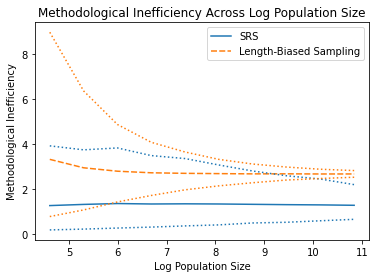

In [14]:
# plotting methodological inefficiency
sns.lineplot(data=agg_all_info[["mean_Inf", "bmean_Inf"]])

# quantiles for SRS simulations
sns.lineplot(x=agg_all_info.index, \
             y=agg_all_info["uq_Inf"], \
             color=sns.color_palette()[0], linestyle="dotted")
sns.lineplot(x=agg_all_info.index, \
             y=agg_all_info["lq_Inf"], \
             color=sns.color_palette()[0], linestyle="dotted")

# quantiles for length-biased simulations
sns.lineplot(x=agg_all_info.index, \
             y=agg_all_info["buq_Inf"], \
             color=sns.color_palette()[1], linestyle="dotted")
sns.lineplot(x=agg_all_info.index, \
             y=agg_all_info["blq_Inf"], \
             color=sns.color_palette()[1], linestyle="dotted")

plt.legend(["SRS", "Length-Biased Sampling"])
plt.title("Methodological Inefficiency Across Log Population Size")
plt.xlabel("Log Population Size")
plt.ylabel("Methodological Inefficiency")
plt.savefig("ch4_2_method_inefficiency.png")

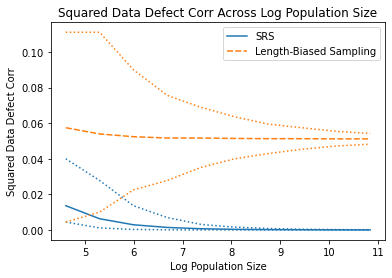

In [15]:
# plotting Squared Data Quality (Data Defect Index)
sns.lineplot(data=agg_all_info[["mean_cor2", "bmean_cor2"]]) 

# quantiles for SRS simulations
sns.lineplot(x=agg_all_info.index, \
             y=agg_all_info["uq_cor2"], \
             color=sns.color_palette()[0], linestyle="dotted")
sns.lineplot(x=agg_all_info.index, \
             y=agg_all_info["lq_cor2"], \
             color=sns.color_palette()[0], linestyle="dotted")

# quantiles for length-biased simulations
sns.lineplot(x=agg_all_info.index, \
             y=agg_all_info["buq_cor2"], \
             color=sns.color_palette()[1], linestyle="dotted")
sns.lineplot(x=agg_all_info.index, \
             y=agg_all_info["blq_cor2"], \
             color=sns.color_palette()[1], linestyle="dotted")

plt.legend(["SRS", "Length-Biased Sampling"])
plt.title("Squared Data Defect Corr Across Log Population Size")
plt.xlabel("Log Population Size")
plt.ylabel("Squared Data Defect Corr")
plt.savefig("ch4_2_method_quality.png")